In [3]:
# ## 2. Load Data
Laos_site_locations = pd.read_csv('/Users/nicolasanderson/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Anderson/Laos/locations2.csv')
Laos_site_data = pd.read_csv('/Users/nicolasanderson/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Anderson/CIT/sites.txt', sep='\t', header=1)
Laos_specimen_data = pd.read_csv('/Users/nicolasanderson/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Anderson/CIT/specimens.txt', sep='\t', header=1)
Laos_measurement_data = pd.read_csv('/Users/nicolasanderson/Library/CloudStorage/OneDrive-CaliforniaInstituteofTechnology/Anderson/CIT/measurements_csd.txt', sep='\t', header=1)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Filter for 'mt' component in specimens
specimens_mt = Laos_specimen_data.copy()
specimens_mt['dir_comp_norm'] = specimens_mt['dir_comp'].astype(str).str.lower().str.strip()
specimens_mt = specimens_mt[specimens_mt['dir_comp_norm'].str.contains('mt', na=False)]
specimens_mt


# 2. Merge with site locations for age and depth
specimens_mt = specimens_mt.merge(
    Laos_site_locations[['Site', 'Age (ka)', 'Depth']],
    left_on='site', right_on='Site', how='left'
)
specimens_mt

# 3. Aggregate by site (not sample)
mt_summary = specimens_mt.groupby('site').agg(
    mean_inclination=('dir_inc', 'mean'),
    std_inclination=('dir_inc', 'std'),
    n_samples=('dir_inc', 'count'),
    age_ka=('Age (ka)', 'first'),
    depth=('Depth', 'first')
).reset_index()
mt_summary['age_ka'] = pd.to_numeric(mt_summary['age_ka'], errors='coerce')
mt_summary

# 4. Add polarity column (all 'mt' here, or assign by sign if needed)
mt_summary['polarity'] = np.where(mt_summary['mean_inclination'] >= 0, 'Normal', 'Reversed')
mt_summary

,site,mean_inclination,std_inclination,n_samples,age_ka,depth,polarity
0,NWF-A-,19.160000,21.205990,15,518.0,2.0,Normal
1,NWF-B-,-54.185000,10.672654,20,934.0,7.0,Reversed
2,NWF-C-,26.103030,39.785342,33,NaN,NaN,Normal
3,PKQ-A-,33.702410,33.944014,83,NaN,NaN,Normal
4,PKS-B-,-8.442857,5.394706,7,850.0,6.0,Reversed
5,PKS-F-,-5.940244,42.269502,82,NaN,NaN,Reversed
6,PKS-F-1,-2.881818,3.125002,11,NaN,NaN,Reversed
7,PKS-G-,-2.346154,27.168986,26,NaN,NaN,Reversed
8,PKS-H-,-4.454167,21.854141,24,780.0,5.0,Reversed
9,PKS-I-,-38.660000,3.119776,5,553.0,3.0,Reversed


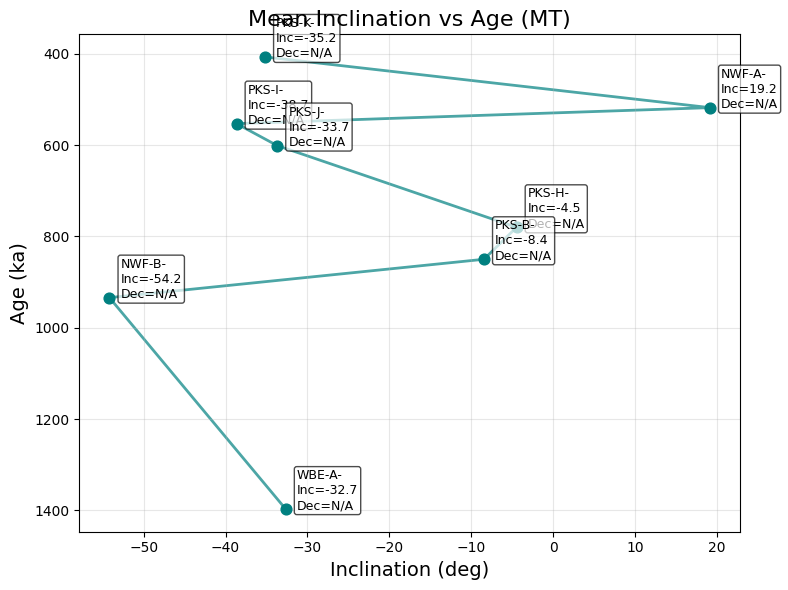

In [8]:
plt.figure(figsize=(8, 6))

# Sort by age for correct line plotting
mt_sorted = mt_summary.sort_values('age_ka')

# Plot line connecting points
plt.plot(mt_sorted['mean_inclination'], mt_sorted['age_ka'], color='teal', linewidth=2, alpha=0.7, zorder=1)

# Scatter points
plt.scatter(mt_sorted['mean_inclination'], mt_sorted['age_ka'], color='teal', s=60, zorder=2)

# Add labels for each point
for _, row in mt_sorted.iterrows():
    label = f"{row['site']}\nInc={row['mean_inclination']:.1f}\nDec={row.get('mean_dec', 'N/A')}"
    plt.annotate(label,
                 (row['mean_inclination'], row['age_ka']),
                 textcoords="offset points", xytext=(8, 0), ha='left', fontsize=9, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

plt.xlabel('Inclination (deg)', fontsize=14)
plt.ylabel('Age (ka)', fontsize=14)
plt.title('Mean Inclination vs Age (MT)', fontsize=16)
plt.gca().invert_yaxis()  # Youngest at top, oldest at bottom
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

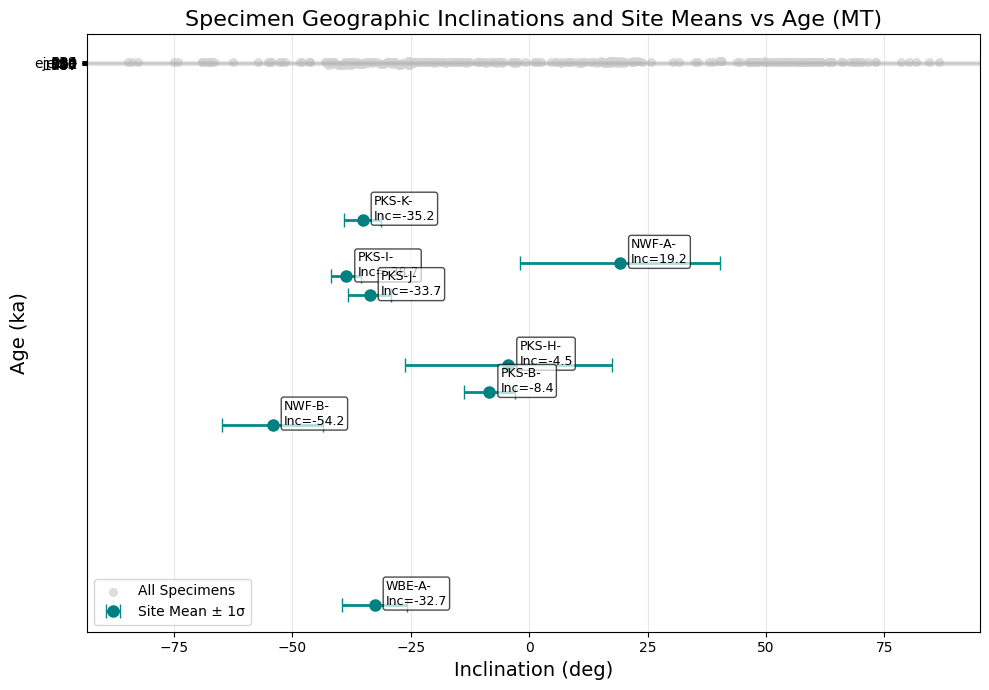

In [10]:
plt.figure(figsize=(10, 7))

# Drop rows with NaN in dir_inc or age_ka for specimens
specimens_plot = specimens_mt.dropna(subset=['dir_inc', 'age_ka'])

# Plot all specimen inclinations (geographic) as points
plt.scatter(
    specimens_plot['dir_inc'],
    specimens_plot['age_ka'],
    color='lightgrey', s=30, alpha=0.7, label='All Specimens'
)

# Plot site means with error bars (means of inclinations)
mt_sorted = mt_summary.dropna(subset=['mean_inclination', 'age_ka']).sort_values('age_ka')
plt.errorbar(
    mt_sorted['mean_inclination'],
    mt_sorted['age_ka'],
    xerr=mt_sorted['std_inclination'],
    fmt='o',
    color='teal',
    ecolor='darkcyan',
    elinewidth=2,
    capsize=5,
    markersize=8,
    label='Site Mean ± 1σ'
)

# Annotate site means
for _, row in mt_sorted.iterrows():
    label = f"{row['site']}\nInc={row['mean_inclination']:.1f}"
    plt.annotate(
        label,
        (row['mean_inclination'], row['age_ka']),
        textcoords="offset points", xytext=(8, 0), ha='left', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7)
    )

plt.xlabel('Inclination (deg)', fontsize=14)
plt.ylabel('Age (ka)', fontsize=14)
plt.title('Specimen Geographic Inclinations and Site Means vs Age (MT)', fontsize=16)
plt.gca().invert_yaxis()  # Youngest at top, oldest at bottom
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
import os
from pathlib import Path

# Directory containing the files
directory = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/PKS-")

# Text to find and replace
old_text = "PKS-K"
new_text = "PKSK"

def replace_in_file(file_path, old_str, new_str):
    """
    Replace all instances of old_str with new_str in a file.
    Returns True if replacements were made, False otherwise.
    """
    try:
        # Read the file content
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            content = f.read()
        
        # Check if old_str exists in content
        if old_str in content:
            # Replace all instances
            new_content = content.replace(old_str, new_str)
            
            # Write back to file
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(new_content)
            
            # Count replacements
            count = content.count(old_str)
            return True, count
        else:
            return False, 0
            
    except Exception as e:
        print(f"   ✗ Error processing {file_path.name}: {e}")
        return False, 0

def process_directory(dir_path, old_text, new_text):
    """
    Process all files in directory and replace text
    """
    if not dir_path.exists():
        print(f"Error: Directory not found: {dir_path}")
        return
    
    print(f"Processing files in: {dir_path}")
    print("=" * 60)
    
    # Get all files in directory (not subdirectories)
    all_files = [f for f in dir_path.iterdir() if f.is_file()]
    
    if not all_files:
        print("No files found in directory.")
        return
    
    print(f"Found {len(all_files)} files\n")
    
    modified_count = 0
    total_replacements = 0
    
    for file_path in sorted(all_files):
        modified, count = replace_in_file(file_path, old_text, new_text)
        
        if modified:
            print(f"✓ {file_path.name}: {count} replacement(s)")
            modified_count += 1
            total_replacements += count
        else:
            print(f"  {file_path.name}: no changes needed")
    
    print("\n" + "=" * 60)
    print(f"Summary:")
    print(f"  Files modified: {modified_count}/{len(all_files)}")
    print(f"  Total replacements: {total_replacements}")
    print("✅ Processing complete!")

# Run the replacement
process_directory(directory, old_text, new_text)

Processing files in: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/PKS-
Found 84 files

✓ LT1 77.UP: 470 replacement(s)
✓ LT1 77.stat: 31 replacement(s)
✓ LT2 77.UP: 300 replacement(s)
✓ LT2 77.stat: 20 replacement(s)
✓ NRM   .UP: 300 replacement(s)
✓ NRM   .stat: 20 replacement(s)
✓ PKS-.log: 2 replacement(s)
✓ PKS-.sam: 9 replacement(s)
  PKS-.xls: no changes needed
  PKS-K-1A: no changes needed
✓ PKS-K-1A.rmg: 1 replacement(s)
  PKS-K-1B: no changes needed
✓ PKS-K-1B.rmg: 1 replacement(s)
  PKS-K-1C: no changes needed
✓ PKS-K-1C.rmg: 1 replacement(s)
  PKS-K-1D: no changes needed
  PKS-K-1E: no changes needed
  PKS-K-2A: no changes needed
✓ PKS-K-2A.rmg: 1 replacement(s)
  PKS-K-2B: no changes needed
✓ PKS-K-2B.rmg: 1 replacement(s)
  PKS-K-2C: no changes needed
✓ PKS-K-2C.rmg: 1 replacement(s)
  PKS-K-2D: no changes needed
✓ PKS-K-2D.rmg: 1 replacement(s)
  PKS-K-2E: no changes needed
✓ PKS-K-2E.rmg: 1 replacement(s)
  PKS-K-2F: no change

In [34]:
import os
from pathlib import Path

def rename_files(dir_path, old_str, new_str):
    """
    Rename all files in directory by replacing old_str with new_str in filenames
    """
    if not dir_path.exists():
        print(f"Error: Directory not found: {dir_path}")
        return
    
    print(f"Renaming files in: {dir_path}")
    print("=" * 60)
    
    # Get all files in directory (not subdirectories)
    all_files = [f for f in dir_path.iterdir() if f.is_file()]
    
    if not all_files:
        print("No files found in directory.")
        return
    
    print(f"Found {len(all_files)} files\n")
    
    renamed_count = 0
    
    for file_path in sorted(all_files):
        old_filename = file_path.name
        
        # Check if old_str is in the filename
        if old_str in old_filename:
            # Create new filename
            new_filename = old_filename.replace(old_str, new_str)
            new_file_path = dir_path / new_filename
            
            # Check if new filename already exists
            if new_file_path.exists():
                print(f"⚠️  {old_filename} → {new_filename} (file already exists, skipping)")
                continue
            
            try:
                # Rename the file
                file_path.rename(new_file_path)
                print(f"✓ {old_filename} → {new_filename}")
                renamed_count += 1
            except Exception as e:
                print(f"✗ Error renaming {old_filename}: {e}")
        else:
            print(f"  {old_filename}: no changes needed")
    
    print("\n" + "=" * 60)
    print(f"Summary:")
    print(f"  Files renamed: {renamed_count}/{len(all_files)}")
    print("✅ Renaming complete!")

# Run the renaming
rename_files(directory, old_text, new_text)

Renaming files in: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/PKS-
Found 84 files

  LT1 77.UP: no changes needed
  LT1 77.stat: no changes needed
  LT2 77.UP: no changes needed
  LT2 77.stat: no changes needed
  NRM   .UP: no changes needed
  NRM   .stat: no changes needed
  PKS-.log: no changes needed
  PKS-.sam: no changes needed
  PKS-.xls: no changes needed
✓ PKS-K-1A → PKSK-1A
✓ PKS-K-1A.rmg → PKSK-1A.rmg
✓ PKS-K-1B → PKSK-1B
✓ PKS-K-1B.rmg → PKSK-1B.rmg
✓ PKS-K-1C → PKSK-1C
✓ PKS-K-1C.rmg → PKSK-1C.rmg
✓ PKS-K-1D → PKSK-1D
✓ PKS-K-1E → PKSK-1E
✓ PKS-K-2A → PKSK-2A
✓ PKS-K-2A.rmg → PKSK-2A.rmg
✓ PKS-K-2B → PKSK-2B
✓ PKS-K-2B.rmg → PKSK-2B.rmg
✓ PKS-K-2C → PKSK-2C
✓ PKS-K-2C.rmg → PKSK-2C.rmg
✓ PKS-K-2D → PKSK-2D
✓ PKS-K-2D.rmg → PKSK-2D.rmg
✓ PKS-K-2E → PKSK-2E
✓ PKS-K-2E.rmg → PKSK-2E.rmg
✓ PKS-K-2F → PKSK-2F
✓ PKS-K-2F.rmg → PKSK-2F.rmg
  PKSJ-1A: no changes needed
  PKSJ-1A.rmg: no changes needed
  PKSJ-1B: no changes needed
  PKS

In [43]:
import pandas as pd
from pathlib import Path

# Define the base directories
magnetometer_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
sam_corrected_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def read_sam_file_orientations(sam_file_path):
    """Read a .sam file and extract orientation data for each specimen"""
    orientations = {}
    
    if not sam_file_path.exists():
        return orientations
    
    with open(sam_file_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines[3:]:
        if line.strip() and not line.startswith('#'):
            parts = line.split()
            if len(parts) >= 5:
                specimen_name = parts[0]
                orientations[specimen_name] = {
                    'specimen': specimen_name,
                    'mag_core_strike': float(parts[1]),
                    'core_dip': float(parts[2]),
                    'bed_strike': float(parts[3]),
                    'bed_dip': float(parts[4])
                }
    
    return orientations

def compile_orientation_corrections(site_name):
    """Compare old and new .sam files for a site"""
    old_sam_file = magnetometer_data_dir / f"{site_name}-" / f"{site_name}-.sam"
    new_sam_file = sam_corrected_dir / f"{site_name}-" / f"{site_name}-.sam"
    
    if not old_sam_file.exists() or not new_sam_file.exists():
        return None
    
    old_orientations = read_sam_file_orientations(old_sam_file)
    new_orientations = read_sam_file_orientations(new_sam_file)
    
    if not old_orientations or not new_orientations:
        return None
    
    orientation_data = []
    
    for specimen_name in old_orientations.keys():
        if specimen_name not in new_orientations:
            continue
        
        old_orient = old_orientations[specimen_name]
        new_orient = new_orientations[specimen_name]
        
        combined = {
            'site': site_name,
            'specimen': specimen_name,
            'old_mag_core_strike': old_orient['mag_core_strike'],
            'old_core_dip': old_orient['core_dip'],
            'old_bed_strike': old_orient['bed_strike'],
            'old_bed_dip': old_orient['bed_dip'],
            'new_mag_core_strike': new_orient['mag_core_strike'],
            'new_core_dip': new_orient['core_dip'],
            'new_bed_strike': new_orient['bed_strike'],
            'new_bed_dip': new_orient['bed_dip'],
            'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
            'dip_correction': new_orient['core_dip'] - old_orient['core_dip'],
            'bed_strike_correction': new_orient['bed_strike'] - old_orient['bed_strike'],
            'bed_dip_correction': new_orient['bed_dip'] - old_orient['bed_dip']
        }
        
        orientation_data.append(combined)
    
    return pd.DataFrame(orientation_data)

# Main execution
all_data = []
print("="*60)
print("CHECKING FILES...")
print("="*60)

for site in sites:
    print(f"\n{site}:")
    old_sam = magnetometer_data_dir / f"{site}-" / f"{site}-.sam"
    new_sam = sam_corrected_dir / f"{site}-" / f"{site}-.sam"
    
    print(f"  Old SAM exists: {old_sam.exists()} - {old_sam}")
    print(f"  New SAM exists: {new_sam.exists()} - {new_sam}")
    
    site_df = compile_orientation_corrections(site)
    if site_df is not None and len(site_df) > 0:
        print(f"  ✓ Found {len(site_df)} specimens")
        all_data.append(site_df)
    else:
        print(f"  ✗ No data compiled")

print("\n" + "="*60)

if all_data:
    df = pd.concat(all_data, ignore_index=True)
    
    print("="*60)
    print("ORIENTATION COMPARISON SUMMARY")
    print("="*60)
    print(f"Total specimens: {len(df)}")
    print(f"Sites: {df['site'].nunique()}")
    
    print(f"\nSTRIKE CORRECTION STATISTICS:")
    print(f"  Range: {df['strike_correction'].min():.2f}° to {df['strike_correction'].max():.2f}°")
    print(f"  Mean: {df['strike_correction'].mean():.2f}°")
    print(f"  Std Dev: {df['strike_correction'].std():.2f}°")
    
    print(f"\nDIP CORRECTION STATISTICS:")
    print(f"  Range: {df['dip_correction'].min():.2f}° to {df['dip_correction'].max():.2f}°")
    print(f"  Mean: {df['dip_correction'].mean():.2f}°")
    print(f"  Std Dev: {df['dip_correction'].std():.2f}°")
    
    print(f"\nSpecimens with >5° strike correction: {len(df[abs(df['strike_correction']) > 5])}")
    print(f"Specimens with >5° dip correction: {len(df[abs(df['dip_correction']) > 5])}")
    
    # Save to CSV
    output_file = magnetometer_data_dir.parent / "orientation_corrections_summary.csv"
    df.to_csv(output_file, index=False)
    print(f"\n✓ Saved to: {output_file}")
    
    # Display sample
    print(f"\n{'='*60}")
    print("SAMPLE DATA (first 15 specimens):")
    print("="*60)
    display_cols = ['site', 'specimen', 'old_mag_core_strike', 'new_mag_core_strike', 
                    'strike_correction', 'old_core_dip', 'new_core_dip', 'dip_correction']
    print(df[display_cols].head(15).to_string(index=False))
    
    print(f"\n{'='*60}")
    print("LARGEST STRIKE CORRECTIONS:")
    print("="*60)
    print(df.nlargest(10, 'strike_correction')[display_cols].to_string(index=False))
else:
    print("No data found to compare")

CHECKING FILES...

NWFA:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFA-/NWFA-.sam
  New SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-/NWFA-.sam
  ✗ No data compiled

NWFB:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFB-/NWFB-.sam
  New SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFB-/NWFB-.sam
  ✗ No data compiled

NWFC:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFC-/NWFC-.sam
  New SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFC-/NWFC-.sam
  ✗ No data compiled

PKQA:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_

In [44]:
import pandas as pd
from pathlib import Path

# Define the base directories
magnetometer_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
sam_corrected_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def read_sam_file_orientations(sam_file_path):
    """Read a .sam file and extract orientation data for each specimen"""
    orientations = {}
    
    if not sam_file_path.exists():
        return orientations
    
    with open(sam_file_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines[3:]:
        if line.strip() and not line.startswith('#'):
            parts = line.split()
            if len(parts) >= 5:
                specimen_name = parts[0]
                orientations[specimen_name] = {
                    'specimen': specimen_name,
                    'mag_core_strike': float(parts[1]),
                    'core_dip': float(parts[2]),
                    'bed_strike': float(parts[3]),
                    'bed_dip': float(parts[4])
                }
    
    return orientations

def compile_orientation_corrections(site_name):
    """Compare old and new .sam files for a site"""
    old_sam_file = magnetometer_data_dir / f"{site_name}-" / f"{site_name}-.sam"
    new_sam_file = sam_corrected_dir / f"{site_name}-" / f"{site_name}-.sam"
    
    if not old_sam_file.exists() or not new_sam_file.exists():
        return None
    
    old_orientations = read_sam_file_orientations(old_sam_file)
    new_orientations = read_sam_file_orientations(new_sam_file)
    
    if not old_orientations or not new_orientations:
        return None
    
    orientation_data = []
    
    for specimen_name in old_orientations.keys():
        if specimen_name not in new_orientations:
            continue
        
        old_orient = old_orientations[specimen_name]
        new_orient = new_orientations[specimen_name]
        
        combined = {
            'site': site_name,
            'specimen': specimen_name,
            'old_mag_core_strike': old_orient['mag_core_strike'],
            'old_core_dip': old_orient['core_dip'],
            'old_bed_strike': old_orient['bed_strike'],
            'old_bed_dip': old_orient['bed_dip'],
            'new_mag_core_strike': new_orient['mag_core_strike'],
            'new_core_dip': new_orient['core_dip'],
            'new_bed_strike': new_orient['bed_strike'],
            'new_bed_dip': new_orient['bed_dip'],
            'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
            'dip_correction': new_orient['core_dip'] - old_orient['core_dip'],
            'bed_strike_correction': new_orient['bed_strike'] - old_orient['bed_strike'],
            'bed_dip_correction': new_orient['bed_dip'] - old_orient['bed_dip']
        }
        
        orientation_data.append(combined)
    
    return pd.DataFrame(orientation_data)

# Main execution
all_data = []
print("="*60)
print("CHECKING FILES...")
print("="*60)

for site in sites:
    print(f"\n{site}:")
    old_sam = magnetometer_data_dir / f"{site}-" / f"{site}-.sam"
    new_sam = sam_corrected_dir / f"{site}-" / f"{site}-.sam"
    
    print(f"  Old SAM exists: {old_sam.exists()} - {old_sam}")
    print(f"  New SAM exists: {new_sam.exists()} - {new_sam}")
    
    site_df = compile_orientation_corrections(site)
    if site_df is not None and len(site_df) > 0:
        print(f"  ✓ Found {len(site_df)} specimens")
        all_data.append(site_df)
    else:
        print(f"  ✗ No data compiled")

print("\n" + "="*60)

if all_data:
    df = pd.concat(all_data, ignore_index=True)
    
    print("="*60)
    print("ORIENTATION COMPARISON SUMMARY")
    print("="*60)
    print(f"Total specimens: {len(df)}")
    print(f"Sites processed: {', '.join(df['site'].unique())}")
    
    print(f"\nSTRIKE CORRECTION STATISTICS:")
    print(f"  Range: {df['strike_correction'].min():.2f}° to {df['strike_correction'].max():.2f}°")
    print(f"  Mean: {df['strike_correction'].mean():.2f}°")
    print(f"  Median: {df['strike_correction'].median():.2f}°")
    print(f"  Std Dev: {df['strike_correction'].std():.2f}°")
    
    print(f"\nDIP CORRECTION STATISTICS:")
    print(f"  Range: {df['dip_correction'].min():.2f}° to {df['dip_correction'].max():.2f}°")
    print(f"  Mean: {df['dip_correction'].mean():.2f}°")
    print(f"  Median: {df['dip_correction'].median():.2f}°")
    print(f"  Std Dev: {df['dip_correction'].std():.2f}°")
    
    print(f"\nBEDDING STRIKE CORRECTION STATISTICS:")
    print(f"  Range: {df['bed_strike_correction'].min():.2f}° to {df['bed_strike_correction'].max():.2f}°")
    print(f"  Mean: {df['bed_strike_correction'].mean():.2f}°")
    print(f"  Median: {df['bed_strike_correction'].median():.2f}°")
    
    print(f"\nBEDDING DIP CORRECTION STATISTICS:")
    print(f"  Range: {df['bed_dip_correction'].min():.2f}° to {df['bed_dip_correction'].max():.2f}°")
    print(f"  Mean: {df['bed_dip_correction'].mean():.2f}°")
    print(f"  Median: {df['bed_dip_correction'].median():.2f}°")
    
    print(f"\nSIGNIFICANT CORRECTIONS (>5°):")
    print(f"  Strike corrections >5°: {len(df[abs(df['strike_correction']) > 5])}")
    print(f"  Dip corrections >5°: {len(df[abs(df['dip_correction']) > 5])}")
    print(f"  Bedding strike corrections >5°: {len(df[abs(df['bed_strike_correction']) > 5])}")
    print(f"  Bedding dip corrections >5°: {len(df[abs(df['bed_dip_correction']) > 5])}")
    
    print(f"\n{'='*60}")
    print("BREAKDOWN BY SITE:")
    print("="*60)
    for site in df['site'].unique():
        site_data = df[df['site'] == site]
        print(f"\n{site}:")
        print(f"  Specimens: {len(site_data)}")
        print(f"  Mean strike correction: {site_data['strike_correction'].mean():.2f}°")
        print(f"  Mean dip correction: {site_data['dip_correction'].mean():.2f}°")
    
    # Display ALL specimens
    print(f"\n{'='*60}")
    print(f"ALL SPECIMENS ({len(df)} total):")
    print("="*60)
    display_cols = ['site', 'specimen', 'old_mag_core_strike', 'new_mag_core_strike', 
                    'strike_correction', 'old_core_dip', 'new_core_dip', 'dip_correction']
    print(df[display_cols].to_string(index=False))
    
    print(f"\n{'='*60}")
    print("✓ COMPARISON COMPLETE - NO FILES MODIFIED")
    print("="*60)
else:
    print("No data found to compare")

CHECKING FILES...

NWFA:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFA-/NWFA-.sam
  New SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-/NWFA-.sam
  ✗ No data compiled

NWFB:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFB-/NWFB-.sam
  New SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFB-/NWFB-.sam
  ✗ No data compiled

NWFC:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFC-/NWFC-.sam
  New SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFC-/NWFC-.sam
  ✗ No data compiled

PKQA:
  Old SAM exists: True - /Users/nicolasanderson/Documents/GitHub/2024_Laos_

In [46]:
import pandas as pd
from pathlib import Path

# Define the base directories
old_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
new_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# Site to process
site = 'NWFA'

def read_specimen_file_orientation(spec_file_path):
    """
    Read a specimen file and extract orientation data from the second line
    Returns dict with orientation data or None if file doesn't exist/can't be read
    """
    if not spec_file_path.exists():
        return None
    
    try:
        with open(spec_file_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line is specimen name
        specimen_name = lines[0].strip()
        
        # Second line contains orientation data
        orientation_line = lines[1].strip()
        parts = orientation_line.split()
        
        if len(parts) >= 5:
            return {
                'specimen': specimen_name,
                'mag_core_strike': float(parts[0]),
                'core_dip': float(parts[1]),
                'bed_strike': float(parts[2]),
                'bed_dip': float(parts[3]),
                'mass': float(parts[4])
            }
    except Exception as e:
        print(f"  Error reading {spec_file_path.name}: {e}")
        return None
    
    return None

def get_specimen_files(site_dir):
    """Get all extensionless specimen files in a directory"""
    all_files = []
    for item in site_dir.iterdir():
        if item.is_file() and not item.suffix:  # No extension
            all_files.append(item)
    return sorted(all_files)

# Main comparison
print("="*60)
print(f"COMPARING SPECIMEN FILES FOR SITE: {site}")
print("="*60)

old_site_dir = old_data_dir / f"{site}-"
new_site_dir = new_data_dir / f"{site}-"

print(f"\nOld directory: {old_site_dir}")
print(f"New directory: {new_site_dir}")

if not old_site_dir.exists():
    print(f"\n❌ Old directory not found!")
elif not new_site_dir.exists():
    print(f"\n❌ New directory not found!")
else:
    # Get specimen files from old directory
    old_files = get_specimen_files(old_site_dir)
    print(f"\nFound {len(old_files)} files in old directory")
    
    # Get specimen files from new directory
    new_files = get_specimen_files(new_site_dir)
    print(f"Found {len(new_files)} files in new directory")
    
    # Get specimen names from old files
    old_specimen_names = [f.name for f in old_files]
    new_specimen_names = [f.name for f in new_files]
    
    # Find common specimens
    common_specimens = set(old_specimen_names) & set(new_specimen_names)
    print(f"\nCommon specimens: {len(common_specimens)}")
    
    if len(common_specimens) == 0:
        print("\n❌ No common specimens found!")
        print(f"\nOld specimens (first 10): {old_specimen_names[:10]}")
        print(f"New specimens (first 10): {new_specimen_names[:10]}")
    else:
        # Compare orientations
        comparison_data = []
        
        print(f"\nComparing orientations...")
        for specimen_name in sorted(common_specimens):
            old_file = old_site_dir / specimen_name
            new_file = new_site_dir / specimen_name
            
            old_orient = read_specimen_file_orientation(old_file)
            new_orient = read_specimen_file_orientation(new_file)
            
            if old_orient and new_orient:
                comparison_data.append({
                    'specimen': specimen_name,
                    'old_mag_core_strike': old_orient['mag_core_strike'],
                    'old_core_dip': old_orient['core_dip'],
                    'old_bed_strike': old_orient['bed_strike'],
                    'old_bed_dip': old_orient['bed_dip'],
                    'new_mag_core_strike': new_orient['mag_core_strike'],
                    'new_core_dip': new_orient['core_dip'],
                    'new_bed_strike': new_orient['bed_strike'],
                    'new_bed_dip': new_orient['bed_dip'],
                    'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
                    'dip_correction': new_orient['core_dip'] - old_orient['core_dip'],
                    'bed_strike_correction': new_orient['bed_strike'] - old_orient['bed_strike'],
                    'bed_dip_correction': new_orient['bed_dip'] - old_orient['bed_dip']
                })
        
        if comparison_data:
            df = pd.DataFrame(comparison_data)
            
            print(f"\n{'='*60}")
            print("ORIENTATION COMPARISON RESULTS")
            print("="*60)
            print(f"Total specimens compared: {len(df)}")
            
            print(f"\nSTRIKE CORRECTION STATISTICS:")
            print(f"  Range: {df['strike_correction'].min():.2f}° to {df['strike_correction'].max():.2f}°")
            print(f"  Mean: {df['strike_correction'].mean():.2f}°")
            print(f"  Median: {df['strike_correction'].median():.2f}°")
            print(f"  Std Dev: {df['strike_correction'].std():.2f}°")
            
            print(f"\nDIP CORRECTION STATISTICS:")
            print(f"  Range: {df['dip_correction'].min():.2f}° to {df['dip_correction'].max():.2f}°")
            print(f"  Mean: {df['dip_correction'].mean():.2f}°")
            print(f"  Median: {df['dip_correction'].median():.2f}°")
            print(f"  Std Dev: {df['dip_correction'].std():.2f}°")
            
            print(f"\nSIGNIFICANT CORRECTIONS (>5°):")
            print(f"  Strike corrections >5°: {len(df[abs(df['strike_correction']) > 5])}")
            print(f"  Dip corrections >5°: {len(df[abs(df['dip_correction']) > 5])}")
            
            # Display all specimens
            print(f"\n{'='*60}")
            print(f"ALL SPECIMENS ({len(df)} total):")
            print("="*60)
            display_cols = ['specimen', 'old_mag_core_strike', 'new_mag_core_strike', 
                            'strike_correction', 'old_core_dip', 'new_core_dip', 'dip_correction']
            print(df[display_cols].to_string(index=False))
            
            print(f"\n{'='*60}")
            print("✓ COMPARISON COMPLETE - NO FILES MODIFIED")
            print("="*60)
        else:
            print("\n❌ Could not read orientation data from files")

COMPARING SPECIMEN FILES FOR SITE: NWFA

Old directory: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFA-
New directory: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-

Found 24 files in old directory
Found 24 files in new directory

Common specimens: 24

Comparing orientations...
  Error reading .DS_Store: 'utf-8' codec can't decode byte 0x87 in position 27: invalid start byte
  Error reading .DS_Store: 'utf-8' codec can't decode byte 0xbb in position 549: invalid start byte

ORIENTATION COMPARISON RESULTS
Total specimens compared: 23

STRIKE CORRECTION STATISTICS:
  Range: 200.00° to 273.00°
  Mean: 249.96°
  Median: 272.00°
  Std Dev: 28.66°

DIP CORRECTION STATISTICS:
  Range: 80.30° to 291.00°
  Mean: 233.10°
  Median: 282.10°
  Std Dev: 69.65°

SIGNIFICANT CORRECTIONS (>5°):
  Strike corrections >5°: 23
  Dip corrections >5°: 23

ALL SPECIMENS (23 total):
specimen  old_mag_cor

In [50]:
import pandas as pd
from pathlib import Path

# Define the base directories
old_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
new_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# Site to process
site = 'NWFA'

def read_specimen_file_orientation(spec_file_path):
    """
    Read a specimen file and extract orientation data from the second line
    Returns dict with orientation data or None if file doesn't exist/can't be read
    """
    if not spec_file_path.exists():
        return None
    
    try:
        with open(spec_file_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line is specimen name
        specimen_name = lines[0].strip()
        
        # Second line contains orientation data
        # Skip first 8 characters (spaces and potentially age)
        orientation_line = lines[1][8:].strip()
        parts = orientation_line.split()
        
        if len(parts) >= 5:
            return {
                'specimen': specimen_name,
                'mag_core_strike': float(parts[0]),
                'core_dip': float(parts[1]),
                'bed_strike': float(parts[2]),
                'bed_dip': float(parts[3]),
                'mass': float(parts[4])
            }
    except Exception as e:
        print(f"  Error reading {spec_file_path.name}: {e}")
        return None
    
    return None

def get_specimen_files(site_dir):
    """Get all extensionless specimen files in a directory (excluding system files)"""
    all_files = []
    for item in site_dir.iterdir():
        # Skip system files and only include extensionless files
        if item.is_file() and not item.suffix and item.name != '.DS_Store':
            all_files.append(item)
    return sorted(all_files)

# Main comparison
print("="*60)
print(f"COMPARING SPECIMEN FILES FOR SITE: {site}")
print("="*60)

old_site_dir = old_data_dir / f"{site}-"
new_site_dir = new_data_dir / f"{site}-"

print(f"\nOld directory: {old_site_dir}")
print(f"New directory: {new_site_dir}")

if not old_site_dir.exists():
    print(f"\n❌ Old directory not found!")
elif not new_site_dir.exists():
    print(f"\n❌ New directory not found!")
else:
    # Get specimen files from old directory
    old_files = get_specimen_files(old_site_dir)
    print(f"\nFound {len(old_files)} files in old directory")
    
    # Get specimen files from new directory
    new_files = get_specimen_files(new_site_dir)
    print(f"Found {len(new_files)} files in new directory")
    
    # Get specimen names from old files
    old_specimen_names = [f.name for f in old_files]
    new_specimen_names = [f.name for f in new_files]
    
    # Find common specimens
    common_specimens = set(old_specimen_names) & set(new_specimen_names)
    print(f"\nCommon specimens: {len(common_specimens)}")
    
    if len(common_specimens) == 0:
        print("\n❌ No common specimens found!")
        print(f"\nOld specimens (first 10): {old_specimen_names[:10]}")
        print(f"New specimens (first 10): {new_specimen_names[:10]}")
    else:
        # Compare orientations
        comparison_data = []
        
        print(f"\nComparing orientations...")
        for specimen_name in sorted(common_specimens):
            old_file = old_site_dir / specimen_name
            new_file = new_site_dir / specimen_name
            
            old_orient = read_specimen_file_orientation(old_file)
            new_orient = read_specimen_file_orientation(new_file)
            
            if old_orient and new_orient:
                comparison_data.append({
                    'specimen': specimen_name,
                    'old_mag_core_strike': old_orient['mag_core_strike'],
                    'old_core_dip': old_orient['core_dip'],
                    'old_bed_strike': old_orient['bed_strike'],
                    'old_bed_dip': old_orient['bed_dip'],
                    'new_mag_core_strike': new_orient['mag_core_strike'],
                    'new_core_dip': new_orient['core_dip'],
                    'new_bed_strike': new_orient['bed_strike'],
                    'new_bed_dip': new_orient['bed_dip'],
                    'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
                    'dip_correction': new_orient['core_dip'] - old_orient['core_dip'],
                    'bed_strike_correction': new_orient['bed_strike'] - old_orient['bed_strike'],
                    'bed_dip_correction': new_orient['bed_dip'] - old_orient['bed_dip']
                })
        
        if comparison_data:
            df = pd.DataFrame(comparison_data)
            
            print(f"\n{'='*60}")
            print("ORIENTATION COMPARISON RESULTS")
            print("="*60)
            print(f"Total specimens compared: {len(df)}")
            
            print(f"\nSTRIKE CORRECTION STATISTICS:")
            print(f"  Range: {df['strike_correction'].min():.2f}° to {df['strike_correction'].max():.2f}°")
            print(f"  Mean: {df['strike_correction'].mean():.2f}°")
            print(f"  Median: {df['strike_correction'].median():.2f}°")
            print(f"  Std Dev: {df['strike_correction'].std():.2f}°")
            
            print(f"\nDIP CORRECTION STATISTICS:")
            print(f"  Range: {df['dip_correction'].min():.2f}° to {df['dip_correction'].max():.2f}°")
            print(f"  Mean: {df['dip_correction'].mean():.2f}°")
            print(f"  Median: {df['dip_correction'].median():.2f}°")
            print(f"  Std Dev: {df['dip_correction'].std():.2f}°")
            
            print(f"\nSIGNIFICANT CORRECTIONS (>5°):")
            print(f"  Strike corrections >5°: {len(df[abs(df['strike_correction']) > 5])}")
            print(f"  Dip corrections >5°: {len(df[abs(df['dip_correction']) > 5])}")
            
            # Save to CSV
            output_file = old_data_dir.parent / f"{site}_orientation_comparison.csv"
            df.to_csv(output_file, index=False)
            print(f"\n✓ Saved detailed comparison to: {output_file}")
            
            # Display all specimens
            print(f"\n{'='*60}")
            print(f"ALL SPECIMENS ({len(df)} total):")
            print("="*60)
            display_cols = ['specimen', 'old_mag_core_strike', 'new_mag_core_strike', 
                            'strike_correction', 'old_core_dip', 'new_core_dip', 'dip_correction']
            print(df[display_cols].to_string(index=False))
            
            print(f"\n{'='*60}")
            print("✓ COMPARISON COMPLETE")
            print("="*60)
        else:
            print("\n❌ Could not read orientation data from files")

COMPARING SPECIMEN FILES FOR SITE: NWFA

Old directory: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFA-
New directory: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-

Found 23 files in old directory
Found 23 files in new directory

Common specimens: 23

Comparing orientations...

ORIENTATION COMPARISON RESULTS
Total specimens compared: 23

STRIKE CORRECTION STATISTICS:
  Range: -115.70° to 96.10°
  Mean: 26.05°
  Median: 14.50°
  Std Dev: 70.23°

DIP CORRECTION STATISTICS:
  Range: 0.00° to 0.00°
  Mean: 0.00°
  Median: 0.00°
  Std Dev: 0.00°

SIGNIFICANT CORRECTIONS (>5°):
  Strike corrections >5°: 18
  Dip corrections >5°: 0

✓ Saved detailed comparison to: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/NWFA_orientation_comparison.csv

ALL SPECIMENS (23 total):
specimen  old_mag_core_strike  new_mag_core_strike  strike_correction  old_core_dip  new_core_

In [51]:
import pandas as pd
from pathlib import Path

# Define the base directories
old_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
new_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def read_specimen_file_orientation(spec_file_path):
    """
    Read a specimen file and extract orientation data from the second line
    Returns dict with orientation data or None if file doesn't exist/can't be read
    """
    if not spec_file_path.exists():
        return None
    
    try:
        with open(spec_file_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line is specimen name
        specimen_name = lines[0].strip()
        
        # Second line contains orientation data
        # Skip first 8 characters (spaces and potentially age)
        orientation_line = lines[1][8:].strip()
        parts = orientation_line.split()
        
        if len(parts) >= 5:
            return {
                'specimen': specimen_name,
                'mag_core_strike': float(parts[0]),
                'core_dip': float(parts[1]),
                'bed_strike': float(parts[2]),
                'bed_dip': float(parts[3]),
                'mass': float(parts[4])
            }
    except Exception as e:
        return None
    
    return None

def get_specimen_files(site_dir):
    """Get all extensionless specimen files in a directory (excluding system files)"""
    all_files = []
    for item in site_dir.iterdir():
        # Skip system files and only include extensionless files
        if item.is_file() and not item.suffix and item.name != '.DS_Store':
            all_files.append(item)
    return sorted(all_files)

def compare_site(site):
    """Compare specimen files for a single site"""
    print(f"\n{'='*60}")
    print(f"SITE: {site}")
    print("="*60)
    
    old_site_dir = old_data_dir / f"{site}-"
    new_site_dir = new_data_dir / f"{site}-"
    
    if not old_site_dir.exists():
        print(f"  ⚠️  Old directory not found!")
        return None
    
    if not new_site_dir.exists():
        print(f"  ⚠️  New directory not found!")
        return None
    
    # Get specimen files
    old_files = get_specimen_files(old_site_dir)
    new_files = get_specimen_files(new_site_dir)
    
    print(f"  Old files: {len(old_files)}")
    print(f"  New files: {len(new_files)}")
    
    # Find common specimens
    old_specimen_names = [f.name for f in old_files]
    new_specimen_names = [f.name for f in new_files]
    common_specimens = set(old_specimen_names) & set(new_specimen_names)
    
    print(f"  Common specimens: {len(common_specimens)}")
    
    if len(common_specimens) == 0:
        print(f"  ⚠️  No common specimens found!")
        return None
    
    # Compare orientations
    comparison_data = []
    
    for specimen_name in sorted(common_specimens):
        old_file = old_site_dir / specimen_name
        new_file = new_site_dir / specimen_name
        
        old_orient = read_specimen_file_orientation(old_file)
        new_orient = read_specimen_file_orientation(new_file)
        
        if old_orient and new_orient:
            comparison_data.append({
                'site': site,
                'specimen': specimen_name,
                'old_mag_core_strike': old_orient['mag_core_strike'],
                'old_core_dip': old_orient['core_dip'],
                'old_bed_strike': old_orient['bed_strike'],
                'old_bed_dip': old_orient['bed_dip'],
                'new_mag_core_strike': new_orient['mag_core_strike'],
                'new_core_dip': new_orient['core_dip'],
                'new_bed_strike': new_orient['bed_strike'],
                'new_bed_dip': new_orient['bed_dip'],
                'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
                'dip_correction': new_orient['core_dip'] - old_orient['core_dip'],
                'bed_strike_correction': new_orient['bed_strike'] - old_orient['bed_strike'],
                'bed_dip_correction': new_orient['bed_dip'] - old_orient['bed_dip']
            })
    
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        print(f"  ✓ Successfully compared {len(df)} specimens")
        return df
    else:
        print(f"  ⚠️  Could not read orientation data")
        return None

# Main execution
print("="*60)
print("COMPARING SPECIMEN FILES FOR ALL SITES")
print("="*60)

all_site_data = []

for site in sites:
    site_df = compare_site(site)
    if site_df is not None:
        all_site_data.append(site_df)

print(f"\n{'='*60}")
print("OVERALL SUMMARY")
print("="*60)

if all_site_data:
    # Combine all sites
    combined_df = pd.concat(all_site_data, ignore_index=True)
    
    print(f"\nTotal specimens across all sites: {len(combined_df)}")
    print(f"Sites successfully processed: {combined_df['site'].nunique()}")
    
    print(f"\nSTRIKE CORRECTION STATISTICS (ALL SITES):")
    print(f"  Range: {combined_df['strike_correction'].min():.2f}° to {combined_df['strike_correction'].max():.2f}°")
    print(f"  Mean: {combined_df['strike_correction'].mean():.2f}°")
    print(f"  Median: {combined_df['strike_correction'].median():.2f}°")
    print(f"  Std Dev: {combined_df['strike_correction'].std():.2f}°")
    
    print(f"\nDIP CORRECTION STATISTICS (ALL SITES):")
    print(f"  Range: {combined_df['dip_correction'].min():.2f}° to {combined_df['dip_correction'].max():.2f}°")
    print(f"  Mean: {combined_df['dip_correction'].mean():.2f}°")
    print(f"  Median: {combined_df['dip_correction'].median():.2f}°")
    print(f"  Std Dev: {combined_df['dip_correction'].std():.2f}°")
    
    print(f"\nSIGNIFICANT CORRECTIONS (>5°):")
    print(f"  Strike corrections >5°: {len(combined_df[abs(combined_df['strike_correction']) > 5])}")
    print(f"  Dip corrections >5°: {len(combined_df[abs(combined_df['dip_correction']) > 5])}")
    
    print(f"\nBREAKDOWN BY SITE:")
    for site in combined_df['site'].unique():
        site_data = combined_df[combined_df['site'] == site]
        print(f"\n  {site}:")
        print(f"    Specimens: {len(site_data)}")
        print(f"    Mean strike correction: {site_data['strike_correction'].mean():.2f}°")
        print(f"    Mean dip correction: {site_data['dip_correction'].mean():.2f}°")
    
    # Save combined data to CSV
    output_file = old_data_dir.parent / "all_sites_orientation_comparison.csv"
    combined_df.to_csv(output_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"✓ Saved combined data to: {output_file}")
    print("="*60)
    
else:
    print("\n❌ No data could be compared")

COMPARING SPECIMEN FILES FOR ALL SITES

SITE: NWFA
  Old files: 23
  New files: 23
  Common specimens: 23
  ✓ Successfully compared 23 specimens

SITE: NWFB
  Old files: 25
  New files: 25
  Common specimens: 25
  ✓ Successfully compared 25 specimens

SITE: NWFC
  Old files: 44
  New files: 44
  Common specimens: 44
  ✓ Successfully compared 44 specimens

SITE: PKQA
  Old files: 112
  New files: 106
  Common specimens: 106
  ✓ Successfully compared 106 specimens

SITE: PKSB
  Old files: 8
  New files: 8
  Common specimens: 8
  ✓ Successfully compared 8 specimens

SITE: PKSF
  Old files: 118
  New files: 112
  Common specimens: 112
  ✓ Successfully compared 112 specimens

SITE: PKSG
  Old files: 44
  New files: 44
  Common specimens: 44
  ✓ Successfully compared 44 specimens

SITE: PKSH
  Old files: 29
  New files: 29
  Common specimens: 29
  ✓ Successfully compared 29 specimens

SITE: PKSI
  Old files: 7
  New files: 7
  Common specimens: 7
  ✓ Successfully compared 7 specimens

SITE: 

In [53]:
import pandas as pd
from pathlib import Path

# Define the base directories
old_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
new_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def read_specimen_file_orientation(spec_file_path):
    """
    Read a specimen file and extract orientation data from the second line
    Returns dict with orientation data or None if file doesn't exist/can't be read
    """
    if not spec_file_path.exists():
        return None
    
    try:
        with open(spec_file_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line is specimen name
        specimen_name = lines[0].strip()
        
        # Second line contains orientation data
        # Skip first 8 characters (spaces and potentially age)
        orientation_line = lines[1][8:].strip()
        parts = orientation_line.split()
        
        if len(parts) >= 5:
            return {
                'specimen': specimen_name,
                'mag_core_strike': float(parts[0]),
                'core_dip': float(parts[1]),
                'bed_strike': float(parts[2]),
                'bed_dip': float(parts[3]),
                'mass': float(parts[4])
            }
    except Exception as e:
        return None
    
    return None

def get_specimen_files(site_dir):
    """Get all extensionless specimen files in a directory (excluding system files)"""
    all_files = []
    for item in site_dir.iterdir():
        # Skip system files and only include extensionless files
        if item.is_file() and not item.suffix and item.name != '.DS_Store':
            all_files.append(item)
    return sorted(all_files)

def compare_site(site):
    """Compare specimen files for a single site"""
    print(f"\n{'='*60}")
    print(f"SITE: {site}")
    print("="*60)
    
    old_site_dir = old_data_dir / f"{site}-"
    new_site_dir = new_data_dir / f"{site}-"
    
    if not old_site_dir.exists():
        print(f"  ⚠️  Old directory not found!")
        return None
    
    if not new_site_dir.exists():
        print(f"  ⚠️  New directory not found!")
        return None
    
    # Get specimen files
    old_files = get_specimen_files(old_site_dir)
    new_files = get_specimen_files(new_site_dir)
    
    print(f"  Old files: {len(old_files)}")
    print(f"  New files: {len(new_files)}")
    
    # Find common specimens
    old_specimen_names = [f.name for f in old_files]
    new_specimen_names = [f.name for f in new_files]
    common_specimens = set(old_specimen_names) & set(new_specimen_names)
    
    print(f"  Common specimens: {len(common_specimens)}")
    
    if len(common_specimens) == 0:
        print(f"  ⚠️  No common specimens found!")
        return None
    
    # Compare orientations
    comparison_data = []
    
    for specimen_name in sorted(common_specimens):
        old_file = old_site_dir / specimen_name
        new_file = new_site_dir / specimen_name
        
        old_orient = read_specimen_file_orientation(old_file)
        new_orient = read_specimen_file_orientation(new_file)
        
        if old_orient and new_orient:
            comparison_data.append({
                'site': site,
                'specimen': specimen_name,
                'old_mag_core_strike': old_orient['mag_core_strike'],
                'old_core_dip': old_orient['core_dip'],
                'new_mag_core_strike': new_orient['mag_core_strike'],
                'new_core_dip': new_orient['core_dip'],
                'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
                'dip_correction': new_orient['core_dip'] - old_orient['core_dip']
            })
    
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        print(f"  ✓ Successfully compared {len(df)} specimens")
        return df
    else:
        print(f"  ⚠️  Could not read orientation data")
        return None

# Main execution
print("="*60)
print("COMPARING SPECIMEN FILES FOR ALL SITES")
print("="*60)

all_site_data = []

for site in sites:
    site_df = compare_site(site)
    if site_df is not None:
        all_site_data.append(site_df)

print(f"\n{'='*60}")
print("OVERALL SUMMARY")
print("="*60)

if all_site_data:
    # Combine all sites
    combined_df = pd.concat(all_site_data, ignore_index=True)
    
    print(f"\nTotal specimens across all sites: {len(combined_df)}")
    print(f"Sites successfully processed: {combined_df['site'].nunique()}")
    
    print(f"\nSTRIKE CORRECTION STATISTICS (ALL SITES):")
    print(f"  Range: {combined_df['strike_correction'].min():.2f}° to {combined_df['strike_correction'].max():.2f}°")
    print(f"  Mean: {combined_df['strike_correction'].mean():.2f}°")
    print(f"  Median: {combined_df['strike_correction'].median():.2f}°")
    print(f"  Std Dev: {combined_df['strike_correction'].std():.2f}°")
    
    print(f"\nDIP CORRECTION STATISTICS (ALL SITES):")
    print(f"  Range: {combined_df['dip_correction'].min():.2f}° to {combined_df['dip_correction'].max():.2f}°")
    print(f"  Mean: {combined_df['dip_correction'].mean():.2f}°")
    print(f"  Median: {combined_df['dip_correction'].median():.2f}°")
    print(f"  Std Dev: {combined_df['dip_correction'].std():.2f}°")
    
    print(f"\nSIGNIFICANT CORRECTIONS (>5°):")
    print(f"  Strike corrections >5°: {len(combined_df[abs(combined_df['strike_correction']) > 5])}")
    print(f"  Dip corrections >5°: {len(combined_df[abs(combined_df['dip_correction']) > 5])}")
    
    print(f"\nBREAKDOWN BY SITE:")
    for site in combined_df['site'].unique():
        site_data = combined_df[combined_df['site'] == site]
        print(f"\n  {site}:")
        print(f"    Specimens: {len(site_data)}")
        print(f"    Mean strike correction: {site_data['strike_correction'].mean():.2f}°")
        print(f"    Mean dip correction: {site_data['dip_correction'].mean():.2f}°")
    
    # Save combined data to CSV
    output_file = old_data_dir.parent / "all_sites_orientation_comparison.csv"
    combined_df.to_csv(output_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"✓ Saved combined data to: {output_file}")
    print("="*60)
    
else:
    print("\n❌ No data could be compared")


COMPARING SPECIMEN FILES FOR ALL SITES

SITE: NWFA
  Old files: 23
  New files: 23
  Common specimens: 23
  ✓ Successfully compared 23 specimens

SITE: NWFB
  Old files: 25
  New files: 25
  Common specimens: 25
  ✓ Successfully compared 25 specimens

SITE: NWFC
  Old files: 44
  New files: 44
  Common specimens: 44
  ✓ Successfully compared 44 specimens

SITE: PKQA
  Old files: 112
  New files: 106
  Common specimens: 106
  ✓ Successfully compared 106 specimens

SITE: PKSB
  Old files: 8
  New files: 8
  Common specimens: 8
  ✓ Successfully compared 8 specimens

SITE: PKSF
  Old files: 118
  New files: 112
  Common specimens: 112
  ✓ Successfully compared 112 specimens

SITE: PKSG
  Old files: 44
  New files: 44
  Common specimens: 44
  ✓ Successfully compared 44 specimens

SITE: PKSH
  Old files: 29
  New files: 29
  Common specimens: 29
  ✓ Successfully compared 29 specimens

SITE: PKSI
  Old files: 7
  New files: 7
  Common specimens: 7
  ✓ Successfully compared 7 specimens

SITE: 

In [56]:
import pandas as pd
from pathlib import Path

# Define the base directories
old_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
new_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def read_specimen_file_orientation(spec_file_path):
    """
    Read a specimen file and extract orientation data from the second line
    Returns dict with orientation data or None if file doesn't exist/can't be read
    """
    if not spec_file_path.exists():
        return None
    
    try:
        with open(spec_file_path, 'r') as f:
            lines = f.readlines()
        
        if len(lines) < 2:
            return None
        
        # First line is specimen name
        specimen_name = lines[0].strip()
        
        # Second line contains orientation data
        # Skip first 8 characters (spaces and potentially age)
        orientation_line = lines[1][8:].strip()
        parts = orientation_line.split()
        
        if len(parts) >= 5:
            return {
                'specimen': specimen_name,
                'mag_core_strike': float(parts[0]),
                'core_dip': float(parts[1]),
                'bed_strike': float(parts[2]),
                'bed_dip': float(parts[3]),
                'mass': float(parts[4])
            }
    except Exception as e:
        return None
    
    return None

def get_specimen_files(site_dir):
    """Get all extensionless specimen files in a directory (excluding system files)"""
    all_files = []
    for item in site_dir.iterdir():
        # Skip system files and only include extensionless files
        if item.is_file() and not item.suffix and item.name != '.DS_Store':
            all_files.append(item)
    return sorted(all_files)

def check_block_samples(site):
    """Check if block sample CSV exists and verify headers"""
    block_csv = new_data_dir / f"{site}-" / "block" / f"{site}-block.csv"
    
    if not block_csv.exists():
        return None
    
    print(f"\n  📋 Found block sample file: {block_csv}")
    
    # Read the file and show headers
    try:
        df = pd.read_csv(block_csv, skiprows=6)
        headers = list(df.columns)
        
        print(f"\n  Headers found in CSV (after skipping 6 rows):")
        for i, header in enumerate(headers, 1):
            print(f"    {i}. {header}")
        
        # Check if expected columns exist
        expected_cols = ['magnetic_core_strike', 'core_dip', 'shadow_angle', 'sun_core_strike', 
                        'calculated_IGRF', 'IGRF_local_dec', 'calculated_mag_dec', 'core_strike']
        
        missing_cols = [col for col in expected_cols if col not in headers]
        
        if missing_cols:
            print(f"\n  ⚠️  WARNING: Missing expected columns: {missing_cols}")
        else:
            print(f"\n  ✓ All expected columns found!")
        
        return block_csv
        
    except Exception as e:
        print(f"  ❌ Error reading CSV: {e}")
        return None

def read_block_samples(block_csv_path):
    """Read block sample data from CSV"""
    try:
        df = pd.read_csv(block_csv_path, skiprows=6)
        
        # Select only the columns we need
        cols_to_extract = ['magnetic_core_strike', 'core_dip', 'shadow_angle', 'sun_core_strike', 
                          'calculated_IGRF', 'IGRF_local_dec', 'calculated_mag_dec', 'core_strike']
        
        # Check which columns exist
        available_cols = [col for col in cols_to_extract if col in df.columns]
        
        if available_cols:
            return df[available_cols]
        else:
            return None
            
    except Exception as e:
        print(f"  ❌ Error extracting block data: {e}")
        return None
    """Compare specimen files for a single site"""
    print(f"\n{'='*60}")
    print(f"SITE: {site}")
    print("="*60)
    
    old_site_dir = old_data_dir / f"{site}-"
    new_site_dir = new_data_dir / f"{site}-"
    
    if not old_site_dir.exists():
        print(f"  ⚠️  Old directory not found!")
        return None
    
    if not new_site_dir.exists():
        print(f"  ⚠️  New directory not found!")
        return None
    
    # Get specimen files
    old_files = get_specimen_files(old_site_dir)
    new_files = get_specimen_files(new_site_dir)
    
    print(f"  Old files: {len(old_files)}")
    print(f"  New files: {len(new_files)}")
    
    # Find common specimens
    old_specimen_names = [f.name for f in old_files]
    new_specimen_names = [f.name for f in new_files]
    common_specimens = set(old_specimen_names) & set(new_specimen_names)
    
    print(f"  Common specimens: {len(common_specimens)}")
    
    if len(common_specimens) == 0:
        print(f"  ⚠️  No common specimens found!")
        return None
    
    # Compare orientations
    comparison_data = []
    
    for specimen_name in sorted(common_specimens):
        old_file = old_site_dir / specimen_name
        new_file = new_site_dir / specimen_name
        
        old_orient = read_specimen_file_orientation(old_file)
        new_orient = read_specimen_file_orientation(new_file)
        
        if old_orient and new_orient:
            comparison_data.append({
                'site': site,
                'specimen': specimen_name,
                'old_mag_core_strike': old_orient['mag_core_strike'],
                'old_core_dip': old_orient['core_dip'],
                'new_mag_core_strike': new_orient['mag_core_strike'],
                'new_core_dip': new_orient['core_dip'],
                'strike_correction': new_orient['mag_core_strike'] - old_orient['mag_core_strike'],
                'dip_correction': new_orient['core_dip'] - old_orient['core_dip']
            })
    
    if comparison_data:
        df = pd.DataFrame(comparison_data)
        print(f"  ✓ Successfully compared {len(df)} specimens")
        return df
    else:
        print(f"  ⚠️  Could not read orientation data")
        return None

# Main execution
print("="*60)
print("COMPARING SPECIMEN FILES FOR ALL SITES")
print("="*60)

all_site_data = []

for site in sites:
    site_df = compare_site(site)
    if site_df is not None:
        all_site_data.append(site_df)

print(f"\n{'='*60}")
print("OVERALL SUMMARY")
print("="*60)

if all_site_data:
    # Combine all sites
    combined_df = pd.concat(all_site_data, ignore_index=True)
    
    print(f"\nTotal specimens across all sites: {len(combined_df)}")
    print(f"Sites successfully processed: {combined_df['site'].nunique()}")
    
    print(f"\nSTRIKE CORRECTION STATISTICS (ALL SITES):")
    print(f"  Range: {combined_df['strike_correction'].min():.2f}° to {combined_df['strike_correction'].max():.2f}°")
    print(f"  Mean: {combined_df['strike_correction'].mean():.2f}°")
    print(f"  Median: {combined_df['strike_correction'].median():.2f}°")
    print(f"  Std Dev: {combined_df['strike_correction'].std():.2f}°")
    
    print(f"\nDIP CORRECTION STATISTICS (ALL SITES):")
    print(f"  Range: {combined_df['dip_correction'].min():.2f}° to {combined_df['dip_correction'].max():.2f}°")
    print(f"  Mean: {combined_df['dip_correction'].mean():.2f}°")
    print(f"  Median: {combined_df['dip_correction'].median():.2f}°")
    print(f"  Std Dev: {combined_df['dip_correction'].std():.2f}°")
    
    print(f"\nSIGNIFICANT CORRECTIONS (>5°):")
    print(f"  Strike corrections >5°: {len(combined_df[abs(combined_df['strike_correction']) > 5])}")
    print(f"  Dip corrections >5°: {len(combined_df[abs(combined_df['dip_correction']) > 5])}")
    
    print(f"\nBREAKDOWN BY SITE:")
    for site in combined_df['site'].unique():
        site_data = combined_df[combined_df['site'] == site]
        print(f"\n  {site}:")
        print(f"    Specimens: {len(site_data)}")
        print(f"    Mean strike correction: {site_data['strike_correction'].mean():.2f}°")
        print(f"    Mean dip correction: {site_data['dip_correction'].mean():.2f}°")
    
    # Save combined data to CSV
    output_file = old_data_dir.parent / "all_sites_orientation_comparison.csv"
    combined_df.to_csv(output_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"✓ Saved combined data to: {output_file}")
    print("="*60)
    
else:
    print("\n❌ No data could be compared")

COMPARING SPECIMEN FILES FOR ALL SITES

SITE: NWFA
  Old files: 23
  New files: 23
  Common specimens: 23
  ✓ Successfully compared 23 specimens

SITE: NWFB
  Old files: 25
  New files: 25
  Common specimens: 25
  ✓ Successfully compared 25 specimens

SITE: NWFC
  Old files: 44
  New files: 44
  Common specimens: 44
  ✓ Successfully compared 44 specimens

SITE: PKQA
  Old files: 112
  New files: 106
  Common specimens: 106
  ✓ Successfully compared 106 specimens

SITE: PKSB
  Old files: 8
  New files: 8
  Common specimens: 8
  ✓ Successfully compared 8 specimens

SITE: PKSF
  Old files: 118
  New files: 112
  Common specimens: 112
  ✓ Successfully compared 112 specimens

SITE: PKSG
  Old files: 44
  New files: 44
  Common specimens: 44
  ✓ Successfully compared 44 specimens

SITE: PKSH
  Old files: 29
  New files: 29
  Common specimens: 29
  ✓ Successfully compared 29 specimens

SITE: PKSI
  Old files: 7
  New files: 7
  Common specimens: 7
  ✓ Successfully compared 7 specimens

SITE: 

In [59]:
import pandas as pd
from pathlib import Path

# Define the base directory
new_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")
output_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def check_block_samples(site):
    """Check if block sample CSV exists and verify headers"""
    block_csv = new_data_dir / f"{site}-" / "block" / f"{site}-block.csv"
    
    if not block_csv.exists():
        return None
    
    print(f"\n{'='*60}")
    print(f"SITE: {site}")
    print("="*60)
    print(f"Found block sample file: {block_csv}")
    
    # Read the file and show headers
    try:
        df = pd.read_csv(block_csv, skiprows=6)
        headers = list(df.columns)
        
        print(f"\nHeaders found in CSV (after skipping 6 rows):")
        for i, header in enumerate(headers, 1):
            print(f"  {i}. {header}")
        
        # Check if expected columns exist
        expected_cols = ['magnetic_core_strike', 'core_dip', 'shadow_angle', 'sun_core_strike', 
                        'calculated_IGRF', 'IGRF_local_dec', 'calculated_mag_dec', 'core_strike']
        
        missing_cols = [col for col in expected_cols if col not in headers]
        
        if missing_cols:
            print(f"\n⚠️  WARNING: Missing expected columns: {missing_cols}")
        else:
            print(f"\n✓ All expected columns found!")
        
        return block_csv
        
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return None

def read_block_samples(block_csv_path, site):
    """Read block sample data from CSV"""
    try:
        df = pd.read_csv(block_csv_path, skiprows=6)
        
        # Select only the columns we need
        cols_to_extract = ['magnetic_core_strike', 'core_dip', 'shadow_angle', 'sun_core_strike', 
                          'calculated_IGRF', 'IGRF_local_dec', 'calculated_mag_dec', 'core_strike']
        
        # Check which columns exist
        available_cols = [col for col in cols_to_extract if col in df.columns]
        
        if available_cols:
            block_df = df[available_cols].copy()
            block_df['site'] = site
            return block_df
        else:
            return None
            
    except Exception as e:
        print(f"❌ Error extracting block data: {e}")
        return None

# Main execution
print("="*60)
print("EXTRACTING BLOCK SAMPLE DATA")
print("="*60)

all_block_data = []

for site in sites:
    block_csv_path = check_block_samples(site)
    
    if block_csv_path:
        response = input(f"\nProcess block samples for {site}? (yes/no): ")
        if response.lower() in ['yes', 'y']:
            block_data = read_block_samples(block_csv_path, site)
            if block_data is not None:
                print(f"✓ Extracted {len(block_data)} block samples")
                print(f"\nBlock sample data preview:")
                print(block_data.head().to_string(index=False))
                all_block_data.append(block_data)
            else:
                print(f"⚠️  Could not extract block sample data")

print(f"\n{'='*60}")
print("SUMMARY")
print("="*60)

if all_block_data:
    # Combine all block data
    combined_block_df = pd.concat(all_block_data, ignore_index=True)
    
    print(f"\nTotal block samples across all sites: {len(combined_block_df)}")
    print(f"Sites with block samples: {combined_block_df['site'].nunique()}")
    
    print(f"\nBreakdown by site:")
    for site in combined_block_df['site'].unique():
        site_count = len(combined_block_df[combined_block_df['site'] == site])
        print(f"  {site}: {site_count} samples")
    
    # Save to CSV
    block_output_file = output_dir / "all_sites_block_samples.csv"
    combined_block_df.to_csv(block_output_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"✓ Saved block sample data to: {block_output_file}")
    print("="*60)
else:
    print("\n❌ No block sample data found")

EXTRACTING BLOCK SAMPLE DATA

SITE: NWFA
Found block sample file: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-/block/NWFA-block.csv

Headers found in CSV (after skipping 6 rows):
  1. sample_name
  2. comment
  3. strat_level
  4. magnetic_core_strike
  5. core_dip
  6. bedding_strike
  7. bedding_dip
  8. correct_bedding_using_local_dec
  9. shadow_angle
  10. GMT_offset
  11. year
  12. month
  13. days
  14. hours
  15. minutes
  16. mass
  17. runs
  18. sun_core_strike
  19. calculated_IGRF
  20. IGRF_local_dec
  21. calculated_mag_dec
  22. core_strike
  23. corrected_bedding_strike

✓ All expected columns found!
✓ Extracted 5 block samples

Block sample data preview:
 magnetic_core_strike  core_dip  shadow_angle  sun_core_strike                                                                                  calculated_IGRF  IGRF_local_dec  calculated_mag_dec  core_strike site
                  340      65.0           

In [60]:
import numpy as np
import pmagpy.pmag as pmag
from pathlib import Path
import shutil

# Define directories
original_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data")
corrected_sam_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected")
output_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def process_site(site):
    """Process magnetometer data corrections for a single site"""
    print(f"\n{'='*60}")
    print(f"PROCESSING SITE: {site}")
    print("="*60)
    
    # Define paths
    sam_file_path = corrected_sam_dir / f"{site}-" / f"{site}-.sam"
    original_site_dir = original_data_dir / f"{site}-"
    corrected_site_dir = corrected_sam_dir / f"{site}-"
    output_site_dir = output_dir / f"{site}-"
    
    # Check if paths exist
    if not sam_file_path.exists():
        print(f"  ⚠️  SAM file not found: {sam_file_path}")
        return False
    
    if not original_site_dir.exists():
        print(f"  ⚠️  Original data directory not found: {original_site_dir}")
        return False
    
    if not corrected_site_dir.exists():
        print(f"  ⚠️  Corrected SAM directory not found: {corrected_site_dir}")
        return False
    
    # Create output directory
    output_site_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"  SAM file: {sam_file_path}")
    print(f"  Original data: {original_site_dir}")
    print(f"  Corrected orientations: {corrected_site_dir}")
    print(f"  Output: {output_site_dir}")
    
    # Read SAM file to get list of specimens
    with open(sam_file_path, 'r') as sam_file:
        sam_file_lines = sam_file.readlines()[2:]  # Skip first 2 header lines
    
    specimens_processed = 0
    specimens_failed = 0
    
    for i in range(len(sam_file_lines)):
        line = sam_file_lines[i].strip()
        if not line or line.startswith('#'):
            continue
        
        # Get specimen name (first column)
        this_file_path = line.split()[0]
        
        print(f"\n  Processing: {this_file_path}")
        
        # Paths to files
        corrected_spec_file = corrected_site_dir / this_file_path
        original_spec_file = original_site_dir / this_file_path
        output_spec_file = output_site_dir / this_file_path
        
        # Copy .UP file if it exists
        original_up_file = original_site_dir / f"{this_file_path}.UP"
        if original_up_file.exists():
            output_up_file = output_site_dir / f"{this_file_path}.UP"
            shutil.copy2(original_up_file, output_up_file)
        
        # Check if files exist
        if not corrected_spec_file.exists():
            print(f"    ⚠️  Corrected file not found: {corrected_spec_file.name}")
            specimens_failed += 1
            continue
        
        if not original_spec_file.exists():
            print(f"    ⚠️  Original file not found: {original_spec_file.name}")
            specimens_failed += 1
            continue
        
        try:
            # Read corrected orientation from first 2 lines
            with open(corrected_spec_file, 'r') as corrected_file:
                corrected_file_lines = corrected_file.readlines()[:2]
            
            # Parse orientation data (skip first 8 characters as before)
            orientation_parts = corrected_file_lines[1][8:].split()
            correct_core_strike = float(orientation_parts[0])
            correct_core_dip = float(orientation_parts[1])
            bedding_strike = float(orientation_parts[2])
            bedding_dip = float(orientation_parts[3])
            
            # Read original file measurements (skip first 2 header lines)
            with open(original_spec_file, 'r') as incorrect_file:
                incorrect_file_lines = incorrect_file.readlines()[2:]
            
            # Process each measurement line
            for j in range(len(incorrect_file_lines)):
                heading = incorrect_file_lines[j][:7]
                moment_csd = incorrect_file_lines[j][31:46]
                
                # Extract specimen coordinates (columns 45-57)
                this_spec_dec = float(incorrect_file_lines[j][45:51])
                this_spec_inc = float(incorrect_file_lines[j][51:57])
                this_no_change_text = incorrect_file_lines[j][57:]
                
                # Calculate corrected geographic coordinates
                correct_geo_dec = pmag.dogeo(this_spec_dec, this_spec_inc, 
                                            correct_core_strike-90, -correct_core_dip)[0]
                correct_geo_inc = pmag.dogeo(this_spec_dec, this_spec_inc, 
                                            correct_core_strike-90, -correct_core_dip)[1]
                
                # Calculate corrected stratigraphic coordinates
                correct_strat_dec = np.round(pmag.dotilt(correct_geo_dec, correct_geo_inc, 
                                                         bedding_strike-90, -bedding_dip), 1)[0]
                correct_strat_inc = np.round(pmag.dotilt(correct_geo_dec, correct_geo_inc, 
                                                         bedding_strike-90, -bedding_dip), 1)[1]
                
                # Round geographic coordinates
                correct_geo_dec = np.round(correct_geo_dec, 1)
                correct_geo_inc = np.round(correct_geo_inc, 1)
                
                # Construct corrected line
                correct_line = (heading + 
                               '{:05.1f}'.format(correct_geo_dec) + ' ' + 
                               '{:5.1f}'.format(correct_geo_inc) + ' ' + 
                               '{:05.1f}'.format(correct_strat_dec) + ' ' + 
                               '{:5.1f}'.format(correct_strat_inc) + ' ' + 
                               moment_csd + 
                               '{:05.1f}'.format(this_spec_dec) + ' ' + 
                               '{:5.1f}'.format(this_spec_inc) + 
                               this_no_change_text)
                
                corrected_file_lines.append(correct_line)
            
            # Write corrected file
            with open(output_spec_file, 'w', newline='\r\n') as corrected_file:
                corrected_file.writelines(corrected_file_lines)
            
            print(f"    ✓ Corrected {len(incorrect_file_lines)} measurements")
            specimens_processed += 1
            
        except Exception as e:
            print(f"    ✗ Error processing: {e}")
            specimens_failed += 1
    
    # Copy the corrected SAM file to output directory
    output_sam = output_site_dir / f"{site}-.sam"
    shutil.copy2(sam_file_path, output_sam)
    
    print(f"\n  Summary for {site}:")
    print(f"    ✓ Specimens processed: {specimens_processed}")
    print(f"    ✗ Specimens failed: {specimens_failed}")
    print(f"    ✓ Copied SAM file to output")
    
    return specimens_processed > 0

# Main execution
print("="*60)
print("CORRECTING MAGNETOMETER DATA FOR ALL SITES")
print("="*60)

sites_processed = 0
total_success = 0

for site in sites:
    success = process_site(site)
    if success:
        sites_processed += 1

print(f"\n{'='*60}")
print("OVERALL SUMMARY")
print("="*60)
print(f"Sites successfully processed: {sites_processed}/{len(sites)}")
print(f"\nCorrected data saved to: {output_dir}")
print("="*60)

CORRECTING MAGNETOMETER DATA FOR ALL SITES

PROCESSING SITE: NWFA
  SAM file: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-/NWFA-.sam
  Original data: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data/NWFA-
  Corrected orientations: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/SAM_Header-master_corrected/NWFA-
  Output: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected/NWFA-

  Processing: NWFA-1A
    ✓ Corrected 0 measurements

  Processing: NWFA-1B
    ✓ Corrected 25 measurements

  Processing: NWFA-1C
    ✓ Corrected 22 measurements

  Processing: NWFA-1D
    ✓ Corrected 25 measurements

  Processing: NWFA-1E
    ✓ Corrected 22 measurements

  Processing: NWFA-1F
    ✓ Corrected 23 measurements

  Processing: NWFA-1G
    ✓ Corrected 23 measurements

  Processing: NWFA-1H
    ✓ Corrected 22 measurements

  Pro

In [61]:
import pandas as pd
from pathlib import Path

# Define file path
measurements_file = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected/measurements_cleaned.txt")

print("="*60)
print("FILTERING MEASUREMENTS FILE")
print("="*60)

# Check if file exists
if not measurements_file.exists():
    print(f"❌ File not found: {measurements_file}")
else:
    print(f"Reading: {measurements_file}")
    
    # Read the file with header on row 1 (skip row 0)
    df = pd.read_csv(measurements_file, sep='\t', skiprows=1)
    
    print(f"\nOriginal data:")
    print(f"  Total rows: {len(df)}")
    
    # Check if dir_csd column exists
    if 'dir_csd' not in df.columns:
        print(f"\n❌ Column 'dir_csd' not found!")
        print(f"Available columns: {list(df.columns)}")
    else:
        # Show dir_csd statistics
        print(f"\ndir_csd statistics:")
        print(f"  Min: {df['dir_csd'].min():.2f}")
        print(f"  Max: {df['dir_csd'].max():.2f}")
        print(f"  Mean: {df['dir_csd'].mean():.2f}")
        print(f"  Median: {df['dir_csd'].median():.2f}")
        
        # Count rows that will be removed
        rows_to_remove = len(df[df['dir_csd'] > 10])
        print(f"\nRows with dir_csd > 10: {rows_to_remove}")
        
        # Filter the data
        df_filtered = df[df['dir_csd'] <= 10]
        
        print(f"\nFiltered data:")
        print(f"  Remaining rows: {len(df_filtered)}")
        print(f"  Rows removed: {rows_to_remove}")
        print(f"  Percentage removed: {(rows_to_remove/len(df)*100):.1f}%")
        
        # Read the first line (header before column names)
        with open(measurements_file, 'r') as f:
            first_line = f.readline()
        
        # Create backup
        backup_file = measurements_file.with_suffix('.txt.backup')
        print(f"\nCreating backup: {backup_file.name}")
        with open(measurements_file, 'r') as f_in:
            with open(backup_file, 'w') as f_out:
                f_out.write(f_in.read())
        
        # Write filtered data back to file
        with open(measurements_file, 'w') as f:
            # Write the first header line
            f.write(first_line)
            # Write the filtered dataframe
            df_filtered.to_csv(f, sep='\t', index=False)
        
        print(f"\n✓ Filtered file saved to: {measurements_file}")
        print(f"✓ Original file backed up to: {backup_file}")
        
        print("\n" + "="*60)
        print("FILTERING COMPLETE")
        print("="*60)

FILTERING MEASUREMENTS FILE
Reading: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected/measurements_cleaned.txt

Original data:
  Total rows: 6557

dir_csd statistics:
  Min: 0.50
  Max: 86.50
  Mean: 8.15
  Median: 3.60

Rows with dir_csd > 10: 853

Filtered data:
  Remaining rows: 5704
  Rows removed: 853
  Percentage removed: 13.0%

Creating backup: measurements_cleaned.txt.backup

✓ Filtered file saved to: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected/measurements_cleaned.txt
✓ Original file backed up to: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected/measurements_cleaned.txt.backup

FILTERING COMPLETE


In [1]:
import numpy as np
import pmagpy.pmag as pmag
from pathlib import Path

# Define directory with corrected files
corrected_data_dir = Path("/Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected")

# List of sites to process
sites = ['NWFA', 'NWFB', 'NWFC', 'PKQA', 'PKSB', 'PKSF', 'PKSG', 'PKSH', 'PKSI', 'PKSJ', 'PKSK', 'WBEA']

def get_specimen_files(site_dir):
    """Get all extensionless specimen files"""
    all_files = []
    for item in site_dir.iterdir():
        if item.is_file() and not item.suffix and item.name != '.DS_Store' and not item.name.endswith('.sam'):
            all_files.append(item)
    return sorted(all_files)

def process_specimen_file(spec_file_path):
    """
    Recalculate measurements within a single specimen file
    Uses orientation from line 2 and specimen coordinates from measurement lines
    """
    try:
        # Read entire file
        with open(spec_file_path, 'r') as f:
            all_lines = f.readlines()
        
        if len(all_lines) < 3:
            return False, "File too short"
        
        # Line 1: specimen name (keep as-is)
        header_line_1 = all_lines[0]
        
        # Line 2: orientation data (keep as-is)
        header_line_2 = all_lines[1]
        
        # Parse orientation from line 2 (skip first 8 characters)
        orientation_parts = header_line_2[8:].split()
        correct_core_strike = float(orientation_parts[0])
        correct_core_dip = float(orientation_parts[1])
        bedding_strike = float(orientation_parts[2])
        bedding_dip = float(orientation_parts[3])
        
        # Lines 3+: measurement data
        measurement_lines = all_lines[2:]
        
        # Start building new file
        new_file_lines = [header_line_1, header_line_2]
        
        # Process each measurement line
        measurements_processed = 0
        for line in measurement_lines:
            if len(line.strip()) == 0:
                continue
            
            # Parse the line components
            heading = line[:7]  # Treatment code (e.g., "NRM    ", "TT  70 ")
            moment_csd = line[31:46]  # Moment and CSD data
            
            # Extract SPECIMEN coordinates (columns 45-57) - the raw magnetometer data
            this_spec_dec = float(line[45:51].strip())
            this_spec_inc = float(line[51:57].strip())
            
            # Everything after column 57 (operators, timestamps, etc.)
            this_no_change_text = line[57:]
            
            # Calculate corrected GEOGRAPHIC coordinates using current orientation
            correct_geo_dec = pmag.dogeo(this_spec_dec, this_spec_inc, 
                                        correct_core_strike-90, -correct_core_dip)[0]
            correct_geo_inc = pmag.dogeo(this_spec_dec, this_spec_inc, 
                                        correct_core_strike-90, -correct_core_dip)[1]
            
            # Calculate corrected STRATIGRAPHIC coordinates
            correct_strat_dec = np.round(pmag.dotilt(correct_geo_dec, correct_geo_inc, 
                                                     bedding_strike-90, -bedding_dip), 1)[0]
            correct_strat_inc = np.round(pmag.dotilt(correct_geo_dec, correct_geo_inc, 
                                                     bedding_strike-90, -bedding_dip), 1)[1]
            
            # Round geographic coordinates
            correct_geo_dec = np.round(correct_geo_dec, 1)
            correct_geo_inc = np.round(correct_geo_inc, 1)
            
            # Construct corrected line with proper formatting
            # Format: heading(7) + geo_dec(6) + geo_inc(6) + strat_dec(6) + strat_inc(6) + moment_csd(15) + spec_dec(6) + spec_inc(6) + rest
            correct_line = (heading + 
                           '{:05.1f}'.format(correct_geo_dec) + ' ' + 
                           '{:5.1f}'.format(correct_geo_inc) + ' ' + 
                           '{:05.1f}'.format(correct_strat_dec) + ' ' + 
                           '{:5.1f}'.format(correct_strat_inc) + ' ' + 
                           moment_csd + 
                           '{:05.1f}'.format(this_spec_dec) + ' ' + 
                           '{:5.1f}'.format(this_spec_inc) + 
                           this_no_change_text)
            
            new_file_lines.append(correct_line)
            measurements_processed += 1
        
        # Write corrected file back
        with open(spec_file_path, 'w', newline='\r\n') as f:
            f.writelines(new_file_lines)
        
        return True, f"{measurements_processed} measurements"
        
    except Exception as e:
        return False, str(e)

def process_site(site):
    """Process all specimen files in a site"""
    print(f"\n{'='*60}")
    print(f"PROCESSING SITE: {site}")
    print("="*60)
    
    corrected_site_dir = corrected_data_dir / f"{site}-"
    
    if not corrected_site_dir.exists():
        print(f"  ⚠️  Directory not found: {corrected_site_dir}")
        return False
    
    # Get specimen files
    specimen_files = get_specimen_files(corrected_site_dir)
    print(f"  Found {len(specimen_files)} specimen files")
    
    if len(specimen_files) == 0:
        print(f"  ⚠️  No specimen files found")
        return False
    
    specimens_processed = 0
    specimens_failed = 0
    
    for spec_file in specimen_files:
        specimen_name = spec_file.name
        print(f"  Processing: {specimen_name}...", end=' ')
        
        success, message = process_specimen_file(spec_file)
        
        if success:
            print(f"✓ {message}")
            specimens_processed += 1
        else:
            print(f"✗ {message}")
            specimens_failed += 1
    
    print(f"\n  Summary:")
    print(f"    ✓ Processed: {specimens_processed}")
    print(f"    ✗ Failed: {specimens_failed}")
    
    return specimens_processed > 0

# Main execution
print("="*60)
print("RECALCULATE MEASUREMENTS USING CURRENT ORIENTATIONS")
print("="*60)
print("\nThis will recalculate geographic and stratigraphic coordinates")
print("in each corrected specimen file using:")
print("  - Orientation from line 2 of the file")
print("  - Specimen coordinates from measurement lines (columns 45-57)")
print(f"\nFiles location: {corrected_data_dir}")

response = input("\nProceed? (yes/no): ")

if response.lower() in ['yes', 'y']:
    sites_processed = 0
    
    for site in sites:
        success = process_site(site)
        if success:
            sites_processed += 1
    
    print(f"\n{'='*60}")
    print("RECALCULATION COMPLETE")
    print("="*60)
    print(f"Sites successfully processed: {sites_processed}/{len(sites)}")
    print("="*60)
else:
    print("\n❌ Operation cancelled")

RECALCULATE MEASUREMENTS USING CURRENT ORIENTATIONS

This will recalculate geographic and stratigraphic coordinates
in each corrected specimen file using:
  - Orientation from line 2 of the file
  - Specimen coordinates from measurement lines (columns 45-57)

Files location: /Users/nicolasanderson/Documents/GitHub/2024_Laos_Australasian_Impactor/Magnetometer_Data_corrected

PROCESSING SITE: NWFA
  Found 23 specimen files
  Processing: NWFA-1A... ✗ File too short
  Processing: NWFA-1B... ✓ 25 measurements
  Processing: NWFA-1C... ✓ 22 measurements
  Processing: NWFA-1D... ✓ 25 measurements
  Processing: NWFA-1E... ✓ 22 measurements
  Processing: NWFA-1F... ✓ 23 measurements
  Processing: NWFA-1G... ✓ 23 measurements
  Processing: NWFA-1H... ✓ 22 measurements
  Processing: NWFA-1I... ✗ File too short
  Processing: NWFA-2A... ✗ File too short
  Processing: NWFA-2B... ✓ 21 measurements
  Processing: NWFA-2C... ✓ 22 measurements
  Processing: NWFA-2D... ✓ 27 measurements
  Processing: NWFA-